<a href="https://colab.research.google.com/github/quciya/Major-Project/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
! pip install h5py==2.10

In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Input,Reshape, concatenate
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, RepeatVector
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import skimage
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
from warnings import filterwarnings
filterwarnings("ignore")

In [ ]:
"""!pip install split-folders"""

'!pip install split-folders'

In [ ]:
""""import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Major_Project/Image_Dataset/Sagun/', output="/content/drive/MyDrive/Major_Project/Image_Dataset/Sagun/", seed=1337, ratio=(.8, 0.1,0.1)) """"

SyntaxError: ignored

In [ ]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)


In [ ]:
#Load weights
inception = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=True, weights='imagenet', input_tensor=None, classifier_activation="softmax",
)


In [ ]:
#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

In [ ]:
class InceptionImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_dir, img_size=(256,256),batch_size=16,shuffle=True):
        self.batch_size = batch_size
        self.img_dir = img_dir
        self.img_size = img_size
        self.img_list = os.listdir(self.img_dir)
        self.n = len(self.img_list)
        self.shuffle = shuffle
        self.on_epoch_end() 

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.ceil(self.n/self.batch_size))

    def __getitem__(self,index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        batch_filenames = [self.img_list[i] for i in indices]

        X, embed, y = self.__get_data(batch_filenames)
        
        return ([X, embed], y)

    def __get_data(self, batch_filenames):
        
        imgs = []
        for i, fname in enumerate(batch_filenames):
            img = img_to_array(load_img(self.img_dir + fname,target_size=self.img_size))
            imgs.append(img)
        imgs = np.array(imgs)
        #apply on batch
        grayscaled_rgb = gray2rgb(rgb2gray(imgs))
        embed = self.create_inception_embedding(grayscaled_rgb)

        img_lab = rgb2lab(imgs/255.0)
        img_l = np.expand_dims(img_lab[:,:,:,0],-1) #(h,w,1)
        img_ab = img_lab[:,:,:,1:]/128    
        del imgs          
        
        return np.array(img_l),np.array(embed),np.array(img_ab)

    def on_epoch_end(self):
        self.indices = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def create_inception_embedding(self, grayscaled_rgb):

        grayscaled_rgb_resized = []
        for i in grayscaled_rgb:
            i = resize(i, (224, 224, 3), mode='constant')
            grayscaled_rgb_resized.append(i)
        grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
        grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
        embed = inception.predict(grayscaled_rgb_resized)

        return embed


In [ ]:
incep_train_datagen = InceptionImageGenerator('/content/drive/MyDrive/Major_Project/Image_Dataset/Sagun/train/colored/',batch_size=32,img_size=(256,256))
incep_test_datagen = InceptionImageGenerator('/content/drive/MyDrive/Major_Project/Image_Dataset/Sagun/test/colored/',batch_size=32,img_size=(256,256))
incep_valid_datagen = InceptionImageGenerator('/content/drive/MyDrive/Major_Project/Image_Dataset/Sagun/val/colored/',batch_size=32,img_size=(256,256))


In [ ]:
sample = incep_train_datagen[0]
sample[0][0].shape

(32, 256, 256, 1)

In [ ]:
sample[0][1].shape

(32, 1000)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 12  73856       ['conv2d[0][0]']                 
                                8)                                                            

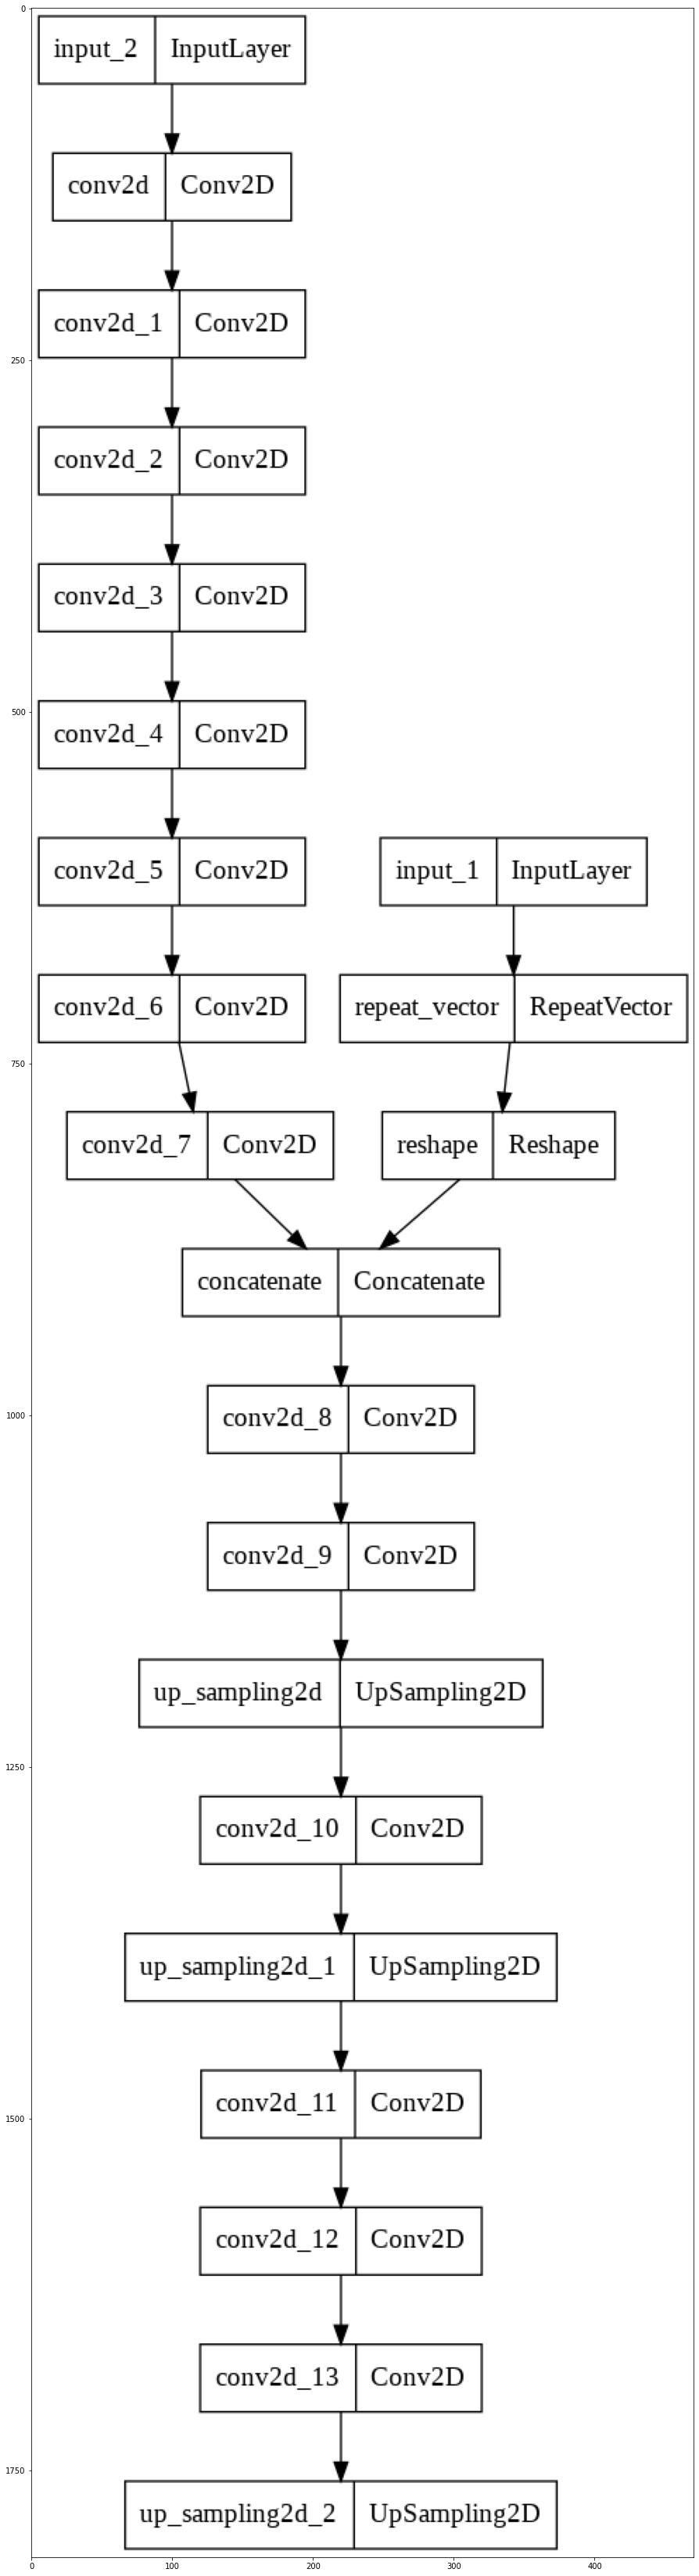

In [ ]:
from tensorflow.keras.utils import plot_model
from PIL import Image
plot_model(model, 'model_diagram.png')
plt.figure(figsize=(100, 60))
plt.imshow(Image.open('model_diagram.png'))

In [ ]:
tensorboard = TensorBoard(log_dir="/content/drive/MyDrive/Major_Project/Final_models")
checkpoint_filepath = '/content/drive/MyDrive/Major_Project/checkpointFinal_models/r'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath+'incep_mse_finetune_{epoch:02d}-{loss:.2f}.h5',
    save_freq=203*5, monitor='val_accuracy', mode='max',verbose=1, save_best_only=True)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mse',metrics=['accuracy','RootMeanSquaredError'])
hist = model.fit(incep_train_datagen,validation_data=incep_valid_datagen,callbacks=[model_checkpoint,tensorboard],epochs=200)

Epoch 1/200
53/53 [==============================] - 128s 2s/step - loss: 0.0130 - accuracy: 0.5198 - root_mean_squared_error: 0.1139 - val_loss: 0.0116 - val_accuracy: 0.5497 - val_root_mean_squared_error: 0.1076
Epoch 2/200
53/53 [==============================] - 108s 2s/step - loss: 0.0119 - accuracy: 0.5662 - root_mean_squared_error: 0.1089 - val_loss: 0.0112 - val_accuracy: 0.5914 - val_root_mean_squared_error: 0.1060
Epoch 3/200
53/53 [==============================] - 106s 2s/step - loss: 0.0116 - accuracy: 0.5888 - root_mean_squared_error: 0.1076 - val_loss: 0.0109 - val_accuracy: 0.5943 - val_root_mean_squared_error: 0.1046
Epoch 4/200
53/53 [==============================] - 101s 2s/step - loss: 0.0112 - accuracy: 0.6135 - root_mean_squared_error: 0.1057 - val_loss: 0.0109 - val_accuracy: 0.6073 - val_root_mean_squared_error: 0.1044
Epoch 5/200
53/53 [==============================] - 102s 2s/step - loss: 0.0110 - accuracy: 0.6082 - root_mean_squared_error: 0.1048 - val_loss

In [ ]:
print(hist.history.keys())

NameError: ignored

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/Major_Project/save_model/Final_modelsefficientnetB0.h5")

In [ ]:
# loading library
import pickle
loc='/content/drive/MyDrive/Major_Project/picklefile/'
# create an iterator object with write permission - model.pkl
with open(loc+'Final_modelsefficientnetB0.pkl', 'wb') as files:
    pickle.dump(hist.history, files)

In [ ]:
# load saved model
with open('/content/drive/MyDrive/Major_Project/picklefile/Final_modelsefficientnetB0.pkl' , 'rb') as f:
    lr = pickle.load(f)

In [ ]:
model.load_weights("/content/drive/MyDrive/Major_Project/save_model/Final_modelsefficientnetB0.h5")

In [ ]:
from glob import glob
import numpy as np
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')
#Give your model directory here
all_pickles = sorted(glob('/content/drive/MyDrive/Major_Project/picklefile/*.pkl'))
model_names = [item[8:-7] for item in all_pickles]
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
train_accuracy=[pickle.load( open( i, "rb" ) )['accuracy'] for i in all_pickles]
valid_accuracy=[pickle.load( open( i, "rb" ) )['accuracy'] for i in all_pickles]
train_rmse=[pickle.load( open( i, "rb" ) )['root_mean_squared_error'] for i in all_pickles]
valid_rmse=[pickle.load( open( i, "rb" ) )['val_root_mean_squared_error'] for i in all_pickles]

num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

#************************************** Training & Valadation Loss Plot*******************************#
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
ax1.legend()  
ax1.set_xlim([1, max(num_epochs,default=0)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
ax2.legend()  
ax2.set_xlim([1, max(num_epochs,default=0)])
plt.xlabel('Epoch')
plt.ylabel('Validation_loss')
plt.show()

#************************************** Training & Valadation accuracy Plot*******************************#
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_accuracy[i], label=model_names[i])
ax1.legend()  
ax1.set_xlim([1, max(num_epochs,default=0)])
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')

ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_accuracy[i], label=model_names[i])
ax2.legend()  
ax2.set_xlim([1, max(num_epochs,default=0)])
plt.xlabel('Epoch')
plt.ylabel('Validation_accuracy')
plt.show()


#************************************** Training & Valadation RMSE Plot*******************************#

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_rmse[i], label=model_names[i])
ax1.legend()  
ax1.set_xlim([1, max(num_epochs,default=0)])
plt.xlabel('Epoch')
plt.ylabel('Train_root_mean_squared_error')

ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_rmse[i], label=model_names[i])
ax2.legend()  
ax2.set_xlim([1, max(num_epochs,default=0)])
plt.xlabel('Epoch')
plt.ylabel('Validation_root_mean_squared_error')
plt.show()

In [ ]:
def to_rgb(gray, ab):
    '''rgb image from grayscale and ab channels'''
    ab = ab*128
    lab_img = np.concatenate((gray,ab),axis=2)
    rgb_img = lab2rgb(lab_img)
    # rgb_img = (rgb_img*255).astype('uint8')
    return rgb_img

In [ ]:
sample = incep_train_datagen[0]      #next(image_a_b_gen(10))
#print(.shape)
prediction = model.predict([sample[0][0],sample[0][1]])
prediction *= 128
op = np.zeros((32,256, 256, 3))
op[:,:,:,0] = sample[0][0][:,:,:,0]
op[:,:,:,1:] = prediction

In [ ]:
original = to_rgb(sample[0][0][4], sample[1][4])

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(lab2rgb(op[4]))
plt.title('Predicted')
plt.subplot(222)
plt.imshow(original)
plt.title('Actual')

In [ ]:
# Test images
test_images = []
for filename in os.listdir('/content/drive/MyDrive/Major_Project/Image_Dataset/Sagun/b&w/'):
    test_images.append(img_to_array(load_img('/content/drive/MyDrive/Major_Project/Image_Dataset/Sagun/b&w/'+filename,target_size=(256,256))))
test_images = np.array(test_images, dtype=float)
Xtest = rgb2lab(1.0/255*test_images)[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*test_images)[:,:,:,1:]
Ytest = Ytest / 128
Xtest_embed = 1.0/255*test_images
Xtest_embed = gray2rgb(rgb2gray(Xtest_embed))
Xtest_embed = create_inception_embedding(Xtest_embed)

# print(model.evaluate(Xtest, Ytest, batch_size=batch_size))
outputs = model.predict([Xtest,Xtest_embed])

predicted = []
actual = []
for i in range(len(Xtest)):
    predicted.append(to_rgb(Xtest[i],outputs[i]))
    actual.append(to_rgb(Xtest[i],Ytest[i]))

In [ ]:
# Plot actual and predicted test images
fig, ax = plt.subplots(20, 2, figsize=(16,100))
row = 0
for img in test_images[60:80]:
    ax[row,0].imshow(img/255.0)
    row +=1

row = 0
for img in predicted[60:80]:
	ax[row,1].imshow(img)
	row +=1
